In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import time

### Set Context

In [24]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### Load Data

In [25]:
batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True
                                                                 , transform=transform)
                                      ,batch_size, shuffle=True)

test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False
                                                                , transform=transform)
                                     , batch_size, shuffle=False)

### Build Net

In [26]:
net = gluon.nn.Dense(num_outputs)

### Initialize Parameters

In [27]:
net.collect_params().initialize(mx.init.Normal(sigma=1.)
                                , ctx=model_ctx
                               )

### Define Multiclass LogLoss

In [28]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Optimizer

In [29]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.01})

### Evaluation Metric

In [30]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [31]:
evaluate_accuracy(test_data, net)

0.0895

### Execute Training Loop

In [32]:
epochs = 1
moving_loss = 0.

start_time = time.time()
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))
    
print(str(time.time()-start_time))

Epoch 0. Loss: 1.01287959783, Train_acc 0.891416666667, Test_acc 0.892
20.4940690994


(10L, 28L, 28L, 1L)


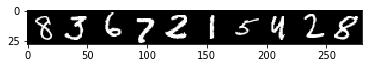

('model predictions are:', 
[ 8.  3.  6.  7.  2.  1.  5.  4.  2.  8.]
<NDArray 10 @cpu(0)>)


In [12]:
def model_predict(net,data):
    output = net(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False
                                                                  , transform=transform)
                                       , 10
                                       , shuffle=True)

for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break

In [33]:
?trainer.step